# Construct IVs for Pooled Sample

The newly enlarged sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def print_full(x):
    """display full table in this notebook"""
    
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', x.shape[1])
    return x
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    

## Convert between calendar date and continuous weeks

In [3]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [4]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [5]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Get sample

In [6]:
# read sample data files
iv_df = pd.read_csv("../data/analytic_df.csv")
print iv_df.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'y_age35', u'y_deceased', u'last_yr', u'attr_before35',
       u'deceased_before35', u'y_child18', u'deceased_child18',
       u'attr_child18'],
      dtype='object')


In [7]:
iv_df = iv_df[['caseid_1979', 'c1dob_y_xrnd', 'c1dob_m_xrnd', 'y_dob', 'm_dob']]
iv_df = iv_df.rename(index=str, columns={"c1dob_y_xrnd": "childbirth_year", "c1dob_m_xrnd":"childbirth_month"})
sample = iv_df.caseid_1979.values.tolist()
print len(sample)

3434


In [8]:
def get_start_month(row):
    """
    Return the month after birth month
    """
    
    if row['childbirth_month'] == 12:
        return 1
    else:
        return row['childbirth_month']+1
 
def get_start_year(row):
    """
    Return the year of the month after birth month
    """
    
    if row['childbirth_month'] == 12:
        return row['childbirth_year']+1
    else:
        return row['childbirth_year']
    
iv_df['start_y'] = iv_df.apply(get_start_year, axis=1)
iv_df['start_m'] = iv_df.apply(get_start_month, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m
0,2,1993,3,1959,1,1993,4
1,3,1981,6,1961,8,1981,7
2,4,1980,8,1962,8,1980,9
3,8,1976,3,1958,7,1976,4
4,16,1990,2,1958,10,1990,3


## Age at first birth 

Use respondent's birth year reported in 1979

In [9]:
def get_age(row):
    """Use both year and month to determine age"""

    return row["childbirth_year"] - row["y_dob"] - (row["childbirth_month"] < row['m_dob'])

iv_df["age"] = iv_df.apply(get_age, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age
0,2,1993,3,1959,1,1993,4,34
1,3,1981,6,1961,8,1981,7,19
2,4,1980,8,1962,8,1980,9,18
3,8,1976,3,1958,7,1976,4,17
4,16,1990,2,1958,10,1990,3,31


## Education

* Type 1: mother gave birth before <= 1979 (so that we lack yearly education variable)

At the time of pulling, if less than age 18 (strictly), assign no hs. Otherwise, use education reported in 1979. 


* Type 2: mother gave birth after > 1979

Use highest grade completed (revised) by the time one year prior to birth --- These variables represent the highest grade completed by the respondent as of May 1 survey year. These are created with some adjustments to keep people from regressing in years of schooling when they take such actions as returning to school in a new field.

In [10]:
hi_grade_df = pd.read_csv('../data/hi_grade_new.csv')
hi_grade_df.head()

,caseid_1979,q3_4_1979,hgc_1979,hgcrev79_1979,q3_4_1980,hgc_1980,hgcrev80_1980,q3_4_1981,hgc_1981,hgcrev81_1981,...,q3_4_2008,hgc_2008,hgcrev08_2008,q3_4_2010,hgc_2010,hgcrev10_2010,q3_4_2012,hgc_2012,q3_4_2014,hgc_2014
0,1,12,12,12,-5,-5,-5,-4,12,12,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,9,9,9,-4,9,9,-4,9,9,...,13,12,12,13,12,12,13,12,12,12
2,3,10,10,10,10,10,10,-5,-5,-5,...,12,12,12,-5,-5,-5,10,12,10,12
3,4,9,9,9,-5,-5,-5,-4,9,9,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,13,13,13,14,14,14,15,15,15,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [11]:
# check different scenarios. merge data to access variables easily 
merged = iv_df.merge(hi_grade_df, on='caseid_1979')

In [12]:
# type 1: mother gave birth before <= 1979
# at the time of pulling, if less than age 18 (strictly), assign no hs
# if >= 18, use education in 1979
age_prebirth = merged[merged.childbirth_year <= 1979].age - 1
age_prebirth.value_counts()

16    183
15    179
17    164
18    123
19     90
14     87
20     46
13     28
21     16
12      3
10      1
Name: age, dtype: int64

In [13]:
def get_hi_grade(row):
    """
    Given a row of a respondent's data, return the highest grade completed by one year prebirth.
    
    If mother gave birth before <= 1979:
        # At the time of pulling, if less than age 18 (strictly), assign no hs
        # Otherwise, use education in 1979
        
    If mother gave birth after > 1979:
        Use the highest grade completed by one year prior to birth
    """
    
    if row['childbirth_year'] <= 1979:
    
        if row['age'] - 1 < 18: # age at one year prebirth < 18
            return -1 # assume less than high school
        else:
            if row['hgcrev79_1979'] >= 0: # valid grade
                return row['hgcrev79_1979']
            else:
                print 'missing pre-1979, respondent %s, grade %s'%(row['caseid_1979'], row['hgcrev79_1979'])
                return None
            
    else:
        
        # up to 2010, revised highest grade is not provided in 2012 or 2014
        years = range(1979, 1995) + range(1996, 2011, 2)

        # do not include grade 95 (which stands for ungraded study)
        # only count until the year prior to birth 
        vals = [row['hgcrev%s_%s'%(str(y)[2:], y)] for y in years 
            if row['hgcrev%s_%s'%(str(y)[2:], y)]<95 and row['hgcrev%s_%s'%(str(y)[2:], y)]>=0 and y<row['childbirth_year']]

        # record the corresponding years in the same order
        #years = [y for y in years 
        #    if row['hgcrev%s_%s'%(str(y)[2:], y)]<95 and row['hgcrev%s_%s'%(str(y)[2:], y)]>=0] 

        #return the highest degree and the year in which it was completed (the earliest year the highest grade appeared)
        if len(vals) > 0:
            return max(vals)
        else:
            print 'missing post-1979, respondent %s, grade %s'%(row['caseid_1979'], row['hgcrev79_1979'])
            return None

        
def recode_educ(g):
    """
    Convert highest grade completed to educational category
    """
    
    if g<12: # less than high school
        return 1
        
    elif g==12: # high school
        return 2
        
    elif (g>12 and g<16): # some college
        return 3
        
    elif g==16: # college graduate
        return 4
        
    elif g>16: # advanced degree
        return 5


merged["hi_deg"] = merged.apply(get_hi_grade, axis=1)
merged["educ"] = merged.hi_deg.map(recode_educ)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,q3_4_1979,hgc_1979,...,hgcrev08_2008,q3_4_2010,hgc_2010,hgcrev10_2010,q3_4_2012,hgc_2012,q3_4_2014,hgc_2014,hi_deg,educ
0,2,1993,3,1959,1,1993,4,34,9,9,...,12,13,12,12,13,12,12,12,12,2
1,3,1981,6,1961,8,1981,7,19,10,10,...,12,-5,-5,-5,10,12,10,12,10,1
2,4,1980,8,1962,8,1980,9,18,9,9,...,-5,-5,-5,-5,-5,-5,-5,-5,9,1
3,8,1976,3,1958,7,1976,4,17,12,12,...,14,14,14,14,14,14,14,14,-1,1
4,16,1990,2,1958,10,1990,3,31,12,12,...,13,13,13,13,12,13,12,13,13,3


In [14]:
# how many missing education? NO MISSING :)
sum(merged.educ.isnull())

0

In [15]:
merged.educ.value_counts()

1    1343
2    1136
3     579
4     281
5      95
Name: educ, dtype: int64

## Pre-birth work experience

In [16]:
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:10]

(12686, 3969)
Index([u'caseid_1979', u'hrs_worked_wk_num0000_xrnd',
       u'hrs_worked_wk_num0001_xrnd', u'hrs_worked_wk_num0002_xrnd',
       u'hrs_worked_wk_num0003_xrnd', u'hrs_worked_wk_num0004_xrnd',
       u'hrs_worked_wk_num0005_xrnd', u'hrs_worked_wk_num0006_xrnd',
       u'hrs_worked_wk_num0007_xrnd', u'hrs_worked_wk_num0008_xrnd'],
      dtype='object')


In [17]:
merged = iv_df.merge(wkarray_df, on='caseid_1979')

In [18]:
def get_unadj_exp(row): 
    """
    Return unadjusted work experience - count all work hours reported before one year pre-birth 
    """

    
    if row["childbirth_year"]-1 < 1978:
        if row['hrs_worked_wk_num0000_xrnd'] == 0: # if we know you never worked pre-1978
            return 0
        else:
            return None

    
    # assume child birth happened in the last week of the month
    end_wk = get_week_num(row["childbirth_year"]-1, row["childbirth_month"], 'last')
    
    # put all valid weekly hours into a list
    hours = [row['hrs_worked_wk_num%04d_xrnd'%w] for w in range(end_wk+1) if row['hrs_worked_wk_num%04d_xrnd'%w]>=0]    

    # count 
    total = end_wk + 1 # total number of weekly hours examined
    total_valid = len(hours) # number of valid weekly hours
        
    
    pct_valid = float(total_valid)/total
    if pct_valid == 1: # if no missing weeks, return sum of hours
        return int(sum(hours))

    elif pct_valid >= 0.9: # if missing <= 10%, expand 
        return int(round(sum(hours)/pct_valid))

    else:
        return None
    

merged["exp"] = merged.apply(get_unadj_exp, axis=1)
iv_df = iv_df.merge(merged[['caseid_1979', 'exp']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp
0,2,1993,3,1959,1,1993,4,34,26370.0
1,3,1981,6,1961,8,1981,7,19,3817.0
2,4,1980,8,1962,8,1980,9,18,0.0
3,8,1976,3,1958,7,1976,4,17,0.0
4,16,1990,2,1958,10,1990,3,31,24275.0


In [19]:
# how many and what proportion of respondents have missing unadjusted experience?
x = sum(iv_df.exp.isnull())
print x, float(x)/iv_df.shape[0]

209 0.0608619685498


In [20]:
# how many missing unadj experience come from mothers who gave first birth before 1978?
print iv_df[(iv_df.exp.isnull())&(iv_df.childbirth_year<=1978)].shape[0]

153


In [21]:
# how many Rs have 0 prebirth experience? 
print iv_df[iv_df.exp==0].shape[0]

#how many Rs had first birth before 1978 and have 0 prebirth experience
print iv_df[((iv_df.childbirth_year<=1978)&(iv_df.exp==0))].shape[0]

844
525


In [22]:
# correlation between exp and age at first birth (after removing cases with missing exp)
nomissing_df = iv_df[~iv_df.exp.isnull()]
np.corrcoef(nomissing_df.exp, nomissing_df.age)

array([[ 1.        ,  0.87340089],
       [ 0.87340089,  1.        ]])

## Two dummy variables: (1) whether working at one year pre-birth and (2) whether ever held job at one year pre-birth

In [23]:
# read job dates data
jobdates_df = pd.read_csv("../data/jobdates.csv")
jobdates_df.head()

,caseid_1979,start_wk_1979_job01_xrnd,start_wk_1979_job02_xrnd,start_wk_1979_job03_xrnd,start_wk_1979_job04_xrnd,start_wk_1979_job05_xrnd,stop_wk_1979_job01_xrnd,stop_wk_1979_job02_xrnd,stop_wk_1979_job03_xrnd,stop_wk_1979_job04_xrnd,...,start_wk_2012_job01_xrnd,start_wk_2012_job02_xrnd,start_wk_2012_job03_xrnd,start_wk_2012_job04_xrnd,start_wk_2012_job05_xrnd,stop_wk_2012_job01_xrnd,stop_wk_2012_job02_xrnd,stop_wk_2012_job03_xrnd,stop_wk_2012_job04_xrnd,stop_wk_2012_job05_xrnd
0,1,21,0,-4,-4,-4,61,20,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,19,-4,-4,-4,-4,60,-4,-4,-4,...,1680,-4,-4,-4,-4,1822,-4,-4,-4,-4
2,3,37,20,5,-4,-4,57,30,15,-4,...,1620,1610,-4,-4,-4,1837,1618,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,5,23,-4,-4,-4,67,35,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [81]:
# how many respondents had birth prior to 1978 and had positive or missing hours prior to 1978?
print iv_df[(iv_df.childbirth_year<=1978)&(iv_df.exp!=0)].shape[0]

153
153


For respondents who had birth prior to 1978 and had positive or missing hours prior to 1978, did any of them have a job start/end week prior to 1/1/1978 (i.e. value 0)? 


YES, and these are jobs with only start week prior to 1/1/1978, all reported in 1979, so I downloaded their job start dates (M/D/Y) - before they are converted to continuous week numbers

In [82]:
sample = iv_df[(iv_df.childbirth_year<=1978)&(iv_df.exp!=0)].caseid_1979.values.tolist()
years = range(1979, 1995) + range(1996, 2013, 2)

for i in sample:
    job_row = jobdates_df[jobdates_df.caseid_1979==i].iloc[0]
    
    for year in years:   
        for j in range(1, 6):
            start = int(job_row['start_wk_%i_job%02d_xrnd'%(year, j)])
            end = int(job_row['stop_wk_%i_job%02d_xrnd'%(year, j)])

            if start == 0 or end == 0:
                print i, year, j, start, end

205 1979 2 0 8
244 1979 1 0 62
244 1979 4 0 55
297 1979 3 0 5
382 1979 3 0 7
491 1979 3 0 13
627 1979 1 0 65
932 1979 2 0 40
995 1979 1 0 60
1057 1979 2 0 1
1111 1979 2 0 58
1189 1979 1 0 60
1209 1979 1 0 59
1225 1979 3 0 33
1238 1979 3 0 3
1376 1979 2 0 31
1406 1979 5 0 7
1495 1979 1 0 63
1517 1979 2 0 61
1552 1979 2 0 28
1559 1979 2 0 6
1600 1979 4 0 3
1760 1979 1 0 57
1824 1979 2 0 54
2036 1979 1 0 59
2105 1979 2 0 33
2193 1979 2 0 53
2196 1979 3 0 34
2311 1979 4 0 5
2447 1979 1 0 56
2528 1979 2 0 13
2742 1979 1 0 58
2746 1979 1 0 60
2834 1979 1 0 60
3021 1979 2 0 9
3036 1979 2 0 33
3041 1979 3 0 16
3316 1979 2 0 30
3445 1979 2 0 21
3705 1979 3 0 22
3769 1979 3 0 33
3779 1979 3 0 11
3927 1979 3 0 13
3986 1979 2 0 11
3992 1979 1 0 65
4041 1979 2 0 26
4041 1979 3 0 17
4105 1979 1 0 58
4136 1979 1 0 64
4179 1979 2 0 26
4268 1979 1 0 59
4280 1979 2 0 54
4325 1979 2 0 11
4400 1979 2 0 13
4450 1979 1 0 60
4476 1979 2 0 50
4483 1979 1 0 56
4538 1979 1 0 62
4780 1979 1 0 61
4974 1979 3 0 32

In [26]:
# read job dates reported in calendar Y/M/D in 1979
jobdates79_df = pd.read_csv('../data/jobdates79.csv')
jobdates79_df.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,employer_stopdate_02_y_1979,employer_stopdate_03_m_1979,employer_stopdate_03_d_1979,employer_stopdate_03_y_1979,employer_stopdate_04_m_1979,employer_stopdate_04_d_1979,employer_stopdate_04_y_1979,employer_stopdate_05_m_1979,employer_stopdate_05_d_1979,employer_stopdate_05_y_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,78,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,78,4,15,78,-4,-4,-4,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,78,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [27]:
# ever held job can be determined by work hours is zero - but this would not handle respondents w/ missing work hours
# let's use job starting and ending dates (in terms of continuous weeks)

count_missing = defaultdict(list) # count how many jobs have missing start or end date

def get_work_dummies(row):
    """
    Determine two dummy variables: (working at one year pre-brith, ever held job at one year pre-birth)
    
    3 scenarios:
    
    1. Pre-birth work experience is zero:
    Set both dummies to zero
    
    2. One year pre-birth is before 1978 and we don't have job starting/ending date information:
    If had positive work hours, assume YES on both variables 
    since we know that they worked at some point in this relatively narrow period
    
    3. One year pre-birth is after 1978, use job dates to determine whether any job overlap with one year prebirth 
    
    """
    ##################
    ### scenario 1 ###
    ##################
    if row['exp'] == 0: 
        return (0, 0)
    
    
    # find birth year and month
    dob_y = int(row['childbirth_year'])
    dob_m = int(row['childbirth_month'])
    
    jobs = []
    
    years = range(1979, 1995) + range(1996, 2013, 2)
    job_row = jobdates_df[jobdates_df.caseid_1979==row['caseid_1979']].iloc[0]
    
    ##################
    ### scenario 2 ###
    ##################   
    if dob_y - 1 < 1978:
        # look for jobs with a start week 0, i.e. started before 1978
        for year in years:   
            for j in range(1, 6):
                start = int(job_row['start_wk_%i_job%02d_xrnd'%(year, j)])
                end = int(job_row['stop_wk_%i_job%02d_xrnd'%(year, j)])

                if start == 0 or end == 0: # then use job start/stop date reported in calendar date
                    job79_row = jobdates79_df[jobdates79_df.caseid_1979==row['caseid_1979']].iloc[0]
                    start_y = int(job79_row['employer_startdate_%02d_y_%s'%(j, year)])
                    start_m = int(job79_row['employer_startdate_%02d_m_%s'%(j, year)])
                    stop_y = int(job79_row['employer_stopdate_%02d_y_%s'%(j, year)])
                    stop_m = int(job79_row['employer_stopdate_%02d_m_%s'%(j, year)])
                    
                    # three respondents had missing start month
                    # one person started the job one year before prebirth year, so it doesn't matter
                    # the other two's job started the same year as prebirth year. assume June
                    if start_m < 0:
                        start_m = 6
                        print 'missing start month: respondent id', row['caseid_1979']
                    
                    if datetime(start_y, start_m, 1) <= datetime(dob_y-1, dob_m, 1):
                        jobs.append(0) # assign 0 to mark that we found a job that started <= the month one year prebirth
                        
                        if stop_y == -4: # held the job until 1979
                            jobs.append(1) # assign 1 to mark that we found a job that overlaps with the month one year prebirth
                        elif datetime(stop_y, stop_m, 1) >= datetime(dob_y-1, dob_m, 1):
                            jobs.append(1)
    
    
    ##################
    ### scenario 3 ###
    ##################
    
    else:
    
        # find all weeks in the month that is one year pre-birth
        # DO NOT assume birth took place in the last week of the month
        birth_weeks = range(get_week_num(dob_y-1, dob_m, 'first'), get_week_num(dob_y-1, dob_m, 'last')+1)

        # first, find all jobs that overlap with birth weeks
        for year in years:   
            for j in range(1, 6):
                start = int(job_row['start_wk_%i_job%02d_xrnd'%(year, j)])
                end = int(job_row['stop_wk_%i_job%02d_xrnd'%(year, j)])

                # only consider jobs with valid starting/ending week number 
                if start >= 0 and end >= 0 and start <= end:
                    if start <= birth_weeks[-1]: # if the job started before one year pre-birth
                        job_weeks = range(start, end+1)
                        if len(set(job_weeks)&set(birth_weeks)) > 0:
                            jobs.append(1) # this job overlaps with one year pre-birth
                        else:
                            jobs.append(0) # this job only started before one year pre-birth, but no overlap
                elif start == -4 and end == -4:
                    pass # valid skip
                else:
                    count_missing[row['caseid_1979']].append((year, j, start, end))
                
    
    # outcome variables to return
    working = 0
    held_job = 0
    
    if 1 in jobs:
        working = 1
    if len(jobs) > 0:
        held_job = 1
        
    return (working, held_job)


dummies = iv_df.apply(get_work_dummies, axis=1)
iv_df['working'] = map(itemgetter(0), dummies)
iv_df['had_job'] = map(itemgetter(1), dummies)
iv_df.head()

missing start month: respondent id 5425.0
missing start month: respondent id 6642.0
missing start month: respondent id 10521.0


,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1
2,4,1980,8,1962,8,1980,9,18,0.0,0,0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1


In [28]:
# how many Rs had missing job dates (reported in continuous week number)?
len(count_missing)

209

In [29]:
# print the first five respondents with missing job dates
# elements in each tuple: (survey year, job number, start week, stop week)

for i in range(len(count_missing)):
    print count_missing.items()[i]
    if i > 5:
        break

(3073.0, [(1990, 2, 602, 600)])
(1538.0, [(2010, 2, -2, 1669)])
(7689.0, [(2010, 1, -2, 1561)])
(3079.0, [(1996, 1, 961, 960)])
(1544.0, [(1994, 2, 817, -3)])
(2569.0, [(1996, 1, 966, 965)])
(5647.0, [(2006, 2, -4, 1380)])


## Marital status at one year pre-birth

In [30]:
marstat_df = pd.read_csv('../data/marstat.csv')
marstat_df.head()

,caseid_1979,marstat_1979,marstat_1980,marstat_1981,marstat_1982,marstat_1983,marstat_1984,marstat_1985,marstat_1986,marstat_1987,...,mobg2m_xrnd,yrbg2m_xrnd,moen2m_xrnd,yren2m_xrnd,mobg3m_xrnd,yrbg3m_xrnd,marstat_2006,marstat_2008,marstat_2010,marstat_2012
0,1,0,-5,0,-5,-5,-5,-5,-5,-5,...,-999,-999,-999,-999,-999,-999,-5,-5,-5,-5
1,2,0,0,0,0,0,0,0,0,0,...,-998,-998,-998,-998,-998,-998,1,1,1,1
2,3,0,0,-5,1,1,1,1,1,1,...,-998,-998,-998,-998,-998,-998,1,1,-5,1
3,4,0,-5,1,1,2,2,2,3,2,...,5,1995,-996,-996,-996,-996,-5,-5,-5,-5
4,5,0,0,0,0,0,0,-5,1,-5,...,-998,-998,-998,-998,-998,-998,-5,-5,-5,-5


In [31]:
# read interview dates
intdate_df = pd.read_csv("../data/int_date.csv") 
intdate_df.head()

,caseid_1979,date_m_1979,date_d_1979,date_m_1980,date_d_1980,date_m_1981,date_d_1981,date_m_1982,date_d_1982,date_m_1983,...,date_y_2006,date_d_2008,date_m_2008,date_y_2008,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012
0,1,3,3,-5,-5,6,25,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,2,28,3,3,2,23,2,6,2,...,2006,4,3,2008,10,3,2010,3,12,2012
2,3,2,8,5,20,-5,-5,3,11,3,...,2006,3,11,2008,-5,-5,-5,19,3,2013
3,4,2,8,-5,-5,3,24,3,3,1,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,4,19,4,3,3,12,3,1,4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [32]:
#how many respondents have missing marriage dates?

missing = []
sample = iv_df.caseid_1979.values.tolist()

for i in sample:
    mar_row = marstat_df[marstat_df.caseid_1979==i].iloc[0]
    
    for j in range(1, 4):
        try: #there is no 'moen3m_xrnd'
            if mar_row['mobg%sm_xrnd'%j] in [-1, -2, -3, -5] \
                or mar_row['yrbg%sm_xrnd'%j] in [-1, -2, -3, -5] \
                or mar_row['moen%sm_xrnd'%j] in [-1, -2, -3, -5] \
                or mar_row['yren%sm_xrnd'%j] in [-1, -2, -3, -5]:
                missing.append(i)
        except KeyError:
            pass
            
print len(missing), len(set(missing))

323 307


In [33]:
# marital status
# how many marriage start/end time overlaps with the month that is one year prior to birth

def overlap(row):
    """
    Return True if a marriage start/end time overlaps with the month that is one year prior to birth
    """
    
    # prebirth
    y = int(row['childbirth_year']) - 1
    m = int(row['childbirth_month'])
    
    mar_row = marstat_df[marstat_df.caseid_1979==row['caseid_1979']].iloc[0]
    
    #Documentation:
    # -999: NEVER MARRIED
    # -998: 1ST MARRIAGE NEVER ENDED
    # -997: 1ST MARRIAGE ENDED NO 2ND MARRIAGE
    # -996: 2ND MARRIAGE NEVER ENDED
    # -995: 2ND MARRIAGE ENDED NO 3RD MARRIAGE
    
    return ((y == mar_row['yrbg1m_xrnd'] and m == mar_row['mobg1m_xrnd']) \
            or (y == mar_row['yren1m_xrnd'] and m == mar_row['moen1m_xrnd']) \
            or (y == mar_row['yrbg2m_xrnd'] and m == mar_row['mobg2m_xrnd']) \
            or (y == mar_row['yren2m_xrnd'] and m == mar_row['moen2m_xrnd']) \
            or (y == mar_row['yrbg3m_xrnd'] and m == mar_row['mobg3m_xrnd']))
    
res = iv_df.apply(overlap, axis=1)
sum(res)

54

In [34]:
# marital status
# 0: never married before
# 1: married
# 2: divorced/separated/widowed

# ASSUME marraige starts/ends in the first week of the month

#NLSY79 marital status key:
#0 NEVER MARRIED
#1 MARRIED
#2 SEPARATED
#3 DIVORCED
#5 REMARRIED
#6 WIDOWED
marstat_dict = {0:0, 1:1, 2:2, 3:2, 6:2} # there is no status 5 in the data
     
years = range(1979, 1995) + range(1996, 2013, 2)
    
    
# helper function
def all_valid(l):
    """
    Return True if no item in the list is a missing value, i.e. -1, -2, -3, -5.
    """
    
    missing = [item<0 for item in l]
    return sum(missing) == 0

   
def correct_marstat(row):
    """
    Sometimes yearly marital status after being married for a while became 0 (single). For example, respondent 9434.
    It should be 3 (divorced). Correct it to 3. 
    """
    
    married_before = False
    for y in years:
        if row['marstat_%s'%y] in [1, 2]:
            married_before = True
            
        if row['marstat_%s'%y] == 0 and married_before:
            row['marstat_%s'%y] = 3
        
    return row
    
    
def get_marstat(row):
    """
    This function returns the marital status at one year prior to first birth, 
    determined using marriage dates (and yearly marriage status if marriage dates are insufficient).
    """
    
    # prebirth
    y = int(row['childbirth_year']) - 1
    m = int(row['childbirth_month'])
        
    #Documentation:
        # -999: NEVER MARRIED
        # -998: 1ST MARRIAGE NEVER ENDED
        # -997: 1ST MARRIAGE ENDED NO 2ND MARRIAGE
        # -996: 2ND MARRIAGE NEVER ENDED
        # -995: 2ND MARRIAGE ENDED NO 3RD MARRIAGE
        # 0 TO 1979: <=1979
        # 1980, etc.
    
    ####################################
    ### Consider various situations: ###
    ####################################


    ### overlap cases ###
    # if overlap with marriage start date, assign married (value 1)
    if ((y == row['yrbg1m_xrnd'] and m == row['mobg1m_xrnd']) \
        or (y == row['yrbg2m_xrnd'] and m == row['mobg2m_xrnd']) \
        or (y == row['yrbg3m_xrnd'] and m == row['mobg3m_xrnd'])):
        return 1
    
    # if overlap with marriage end date, assign previously married (value 2)
    if ((y == row['yren1m_xrnd'] and m == row['moen1m_xrnd']) \
        or (y == row['yren2m_xrnd'] and m == row['moen2m_xrnd'])):
        return 0
    
    
    # never married
    if row['yrbg1m_xrnd'] == -999: 
        return 0
    
    
    # first marriage started after prebirth month 
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): # first check marriage start date is valid
        if datetime(y, m, 1) < datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):
            return 0
    
    
    # prebirth is before 1979 and never married in 1979
    if y < 1979 and row['marstat_1979'] == 0: 
        return 0
    
    
    # first marriage never ended
    if row['yren1m_xrnd'] == -998:
        if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): 
            if datetime(y, m, 1) < datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1): 
                print 'this case has been covered. should not appear'
                return 0
            else:
                return 1
        
        
    # first marriage lasted a finite period of time, and prebirth is in this period
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']]):
        if datetime(y, m, 1) < datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):
            print 'this case has been covered. should not appear'
            return 0
        elif datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
            return 1

    
    # first marriage ended, no second marriage
    if row['yrbg2m_xrnd'] == -997:
        if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
                return 2
    
            
    # prebirth is between first marriage end date and second marriage start date, then R is previously married
    if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd'], row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1):
            return 2
    
    
    # second marriage never ended
    if row['yren2m_xrnd'] == -996:
        if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1): 
                return 1

        
    # second marriage lasted a finite period of time, and prebirth is in this period
    if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
            return 1
     
    
    #2ND MARRIAGE ENDED NO 3RD MARRIAGE                
    if row['yrbg3m_xrnd'] == -995:
        if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
                return 2
            
            
    # prebirth is between second marriage end date and third marriage start date, then R is previously married
    if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd'], row['yrbg3m_xrnd'], row['mobg3m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1):
            return 2
    
    
    ########################################################################################
    ### if marriage dates are insufficient, use yearly marital status and interview date ###
    
    row = correct_marstat(row)
    
    if y in years and all_valid([row['date_m_%i'%y]]):
        
        # the month one year prebirth overlaps with interview date
        if m == row['date_m_%i'%y]: 
            return marstat_dict[row['marstat_%i'%y]]

        
        # the month one year prebirth is before interview date, check marital status in y-1 and y
        elif m < row['date_m_%i'%y]:
            if y >= 1980 and y <= 1994:
                # if marital status in the two surrounding years are the same, use it as prebirth marital status
                if all_valid([row['marstat_%i'%(y-1)], row['marstat_%i'%y]]) and \
                marstat_dict[row['marstat_%i'%(y-1)]] == marstat_dict[row['marstat_%i'%y]]: 
                    return marstat_dict[row['marstat_%i'%y]]
         
        # the month one year prebirth is after interview date, check marital status in y and y+1
        elif m > row['date_m_%i'%y]:
            if y >= 1979 and y <= 1993:
                # if marital status in the two surrounding years are the same, use it as prebirth marital status
                if all_valid([row['marstat_%i'%y], row['marstat_%i'%(y+1)]]) and \
                marstat_dict[row['marstat_%i'%y]] == marstat_dict[row['marstat_%i'%(y+1)]]:
                    return marstat_dict[row['marstat_%i'%y]]
                
            elif y == 1994:
                if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
                marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
                    return marstat_dict[row['marstat_1994']]
    
    elif y == 1995:
        if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
        marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
            return marstat_dict[row['marstat_1994']]
    
    
    return None


merged = iv_df.merge(marstat_df, on='caseid_1979')
merged = merged.merge(intdate_df, on='caseid_1979')
marstat = merged.apply(get_marstat, axis=1)
marstat.value_counts(dropna=False)

 0.0    1884
 1.0    1414
 2.0      86
NaN       50
dtype: int64

In [35]:
# distribution of prebirth year in the None cases
iv_df['marstat'] = marstat
iv_df[iv_df.marstat.isnull()].childbirth_year.value_counts()

1979    9
1983    6
1988    4
1995    4
1977    3
1985    3
1974    3
1978    3
1984    3
1976    2
1987    2
1975    1
1982    1
1992    1
1991    1
1990    1
1989    1
1980    1
1981    1
Name: childbirth_year, dtype: int64

In [36]:
# get relevant information to manually examine the missing cases

partial_df = iv_df[iv_df.marstat.isnull()][['caseid_1979', 'childbirth_year', 'childbirth_month']]
partial_df['prebirth_y'] = partial_df.childbirth_year.map(lambda x: x-1)
partial_df['prebirth_m'] = partial_df.childbirth_month


# drop birth date columns
partial_df = partial_df[['caseid_1979', 'prebirth_y', 'prebirth_m']]


# add interview date in prebirth year (if applicable)
def get_int_date(row):
    if row['prebirth_y'] in years: # is a survey year
        return intdate_df[intdate_df.caseid_1979==row['caseid_1979']].iloc[0]['date_m_%i'%row['prebirth_y']]
    return None
partial_df['int_m_prebirth'] = partial_df.apply(get_int_date, axis=1)

    
# merge with marital status variables
partial_df = partial_df.merge(marstat_df, on='caseid_1979')    
print_full(partial_df)

,caseid_1979,prebirth_y,prebirth_m,int_m_prebirth,marstat_1979,marstat_1980,marstat_1981,marstat_1982,marstat_1983,marstat_1984,marstat_1985,marstat_1986,marstat_1987,marstat_1988,marstat_1989,marstat_1990,marstat_1991,marstat_1992,marstat_1993,marstat_1994,marstat_1996,marstat_1998,marstat_2000,marstat_2002,marstat_2004,mobg1m_xrnd,yrbg1m_xrnd,moen1m_xrnd,yren1m_xrnd,mobg2m_xrnd,yrbg2m_xrnd,moen2m_xrnd,yren2m_xrnd,mobg3m_xrnd,yrbg3m_xrnd,marstat_2006,marstat_2008,marstat_2010,marstat_2012
0,153,1984,2,-5.0,0,-5,-5,-5,-5,-5,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,-2,-2,2,2003,-997,-997,-997,-997,-997,-997,3,3,3,3
1,297,1977,10,NaN,1,1,1,1,1,1,2,2,2,2,2,1,1,1,1,1,1,2,2,2,2,9,1977,-3,-3,7,1990,10,2005,-995,-995,3,3,3,3
2,471,1978,10,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-3,-3,-998,-998,-998,-998,-998,-998,-998,-998,1,1,1,1
3,906,1994,1,8.0,0,0,0,0,0,0,0,0,0,-5,0,0,0,0,0,1,1,1,1,1,3,10,1993,-3,-3,-997,-997,-997,-997,-997,-997,3,3,3,3
4,1212,1973,4,NaN,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,-3,-3,10,1981,-997,-997,-997,-997,-997,-997,3,3,3,3
5,1598,1991,2,6.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,8,1990,-3,-3,-997,-997,-997,-997,-997,-997,1,2,3,3
6,1723,1986,4,-5.0,0,0,0,0,0,0,0,-5,1,-5,-5,-5,-5,1,1,1,1,1,-5,1,1,-1,-1,-998,-998,-998,-998,-998,-998,-998,-998,-5,-5,1,-5
7,2175,1975,12,NaN,2,2,1,2,1,1,1,1,1,1,1,2,2,3,3,3,3,1,1,1,1,6,1975,-3,-3,6,1997,3,2011,7,2012,1,1,2,1
8,2275,1983,9,3.0,0,0,0,0,0,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,1,7,1983,-3,-3,8,1989,-996,-996,-996,-996,1,1,1,1
9,2315,1977,7,NaN,1,2,2,3,3,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,8,1974,9,1974,-3,-3,-3,-3,3,1978,2,1,1,6


In [37]:
partial_df.to_csv('../data/missing_marstat_cases.csv', index=False)

### manually determine the missing cases

* caseid 153, prebirth 1984-2, first marriage start date msising, missing in 1983 and 1984, married in 1985, <font color='red'>**missing**</font>

* caseid 297, prebirth 1977-10, first married in 1977-9, first marriage end date missing, second marriage began in 1990-7, married from 1979 to 1984, so married

* caseid 471, prebirth 1978-10, first marriage began date missing, first marriage never ended, married from 1979 to 2004, can't determine when first married, so <font color='red'>**missing**</font>

* caseid 906, prebirth 1994-1, first marriage started in 1993-10, married from 1004-2002, so married

* caseid 1212, prebirth 1973-4, first marriage start date missing, ended in 1981-10, but separated 1979-1981, don't know since when being separated, so <font color='red'>missing</font>

* caseid 1598, prebirth 1991-2, got married in 1990/8, married in 1991/6. Must be married

* caseid 1723, prebirth 1986-4, first marriage start date missing, single in 1985, missing in 1986, married in 1987, can't decide when marriage started, <font color='red'>**missing**</font>

* caseid 2175, prebirth 1975-12, married in 1975-6, married/separated 1979-1991, so must be married

* caseid 2275, prebirth 1983-9, got married in 1983/7, married in 1984. Must be married. 

* caseid 2315, prebirth 1977-7, married in 1974-8, divorced in 1974-9, second marriage start & end date missing, married again in 1978-3, so can't decide status in 1977-7, <font color='red'>**missing**</font>

* caseid 2458, prebirth 1976-7, first marreid in 1976-4, end date missing, but married until 1987, 2nd marriage started in 1989-7, so married

* caseid 2705, prebirth 1978-10, first married in 1978-9, married until 1996, end date missing, 2nd marriage started in 1999, so married

* caseid 3120, prebirth 1994-1, married in 1990-11, end date missing, divorced in 1993, 2nd marriage started in 1994-6, so divorced

* caseid 3982, prebirth 1978-6, first married in 1978-4, married until 1981, so married

* caseid 4150, prebirth 1989-3, 2nd marriage began in 1987/11, end date missing, separated in 1988/10, married in 1989/6 and 1990/8. 3rd marriage began in 1994. Must be married.

* caseid 4494, prebirth 1984-5, single in 1984/3, married in 1985/5. 1nd marriage start date missing. can't decide, <font color='red'>**missing**</font>

* caseid 4522, prebirth 1987-4, first marriage began in 1987, month missing, missing 1985-1988, <font color='red'>**missing**</font>

* caseid 4713, prebirth 1983-12, single in 1983/3, married in 1984/2, first marriage start date missing, <font color='red'>**missing**</font>

* caseid 5069, prebirth 1977-8, first married in 1976-5, end date missing, 2nd marriage started in 1989, married/separated in 1979-1981, divorced 1982-1989, so married

* caseid 5089, prebirth 1982-7, single in 1982-2, married in 1983, marriage started in 1982-4, so married 

* caseid 5200, prebirth 1978-8, first married in 1976-9, end date missing, 2nd marraige started in 1996, married in 1979-1987, so married

* caseid 5216, prebirth 1982-6, first married in 1978-9, married in 1982-2, separated in 1983, assume married. <i>Treat status 2 as married.</i>
 
* caseid 5247, prebirth 1982-9, irst marriage never ended, marriage start date missin, single in 1982-3, married in 1983, don't know when marriage started, <font color='red'>**missing**</font>

* caseid 5546, prebirth 1994-1, third marriage started in 1993-8, married in 1994-8, so married

* caseid 5888, prebirth 1980-7, single in 1980/3, married in 1981, first marriage start date missing, <font color='red'>**missing**</font>

* caseid 5947, prebirth 1978-4, first marriage start date missing, never ended, married/separated in all years, but can't tell about 1978, <font color='red'>**missing**</font>

* caseid 5948, prebirth 1978-1, first married in 1977-2, end date missing, 2nd marriage started in 1992, married in 1979-1981, so married

* caseid 5983, prebirth 1982-12, single in 1982-3, married in 1983, first marriage started in 1982-8, so married

* caseid 6221, prebirth 1979-2, single in 1979-3, marriage dates missing, must be single

* caseid 6263, prebirth 1976-5, first married in 1975-7, end date missing, 2nd marraig started in 1986, married in 1979-1983, so married

* caseid 6654, prebirth 1978-9, first married in 1977-10, end date missing, 2nd marriage started in 1985, married in 1979-1982, so married

* caseid 6676, prebirth 1978-2, first married in 1977-10, end date missing, 2nd marriage started in 1995, married in 1979-1983, so married

* caseid 6787, prebirth 1974-1, first marriage start date missing, ended in 1982-7, so can't know what happend in 1974, <font color='red'>**missing**</font>

* caseid 7079, prebirth 1973-11, first marriage happend in 1973, but month missing, so can't decide, <font color='red'>**missing**</font>

* caseid 7246, prebirth 1982-3, single in 1981-4, missing in 1982-, married in 1983-4, marriage start date missing, ended in 1988-10, <font color='red'>**missing**</font>

* caseid 7247, prebirth 1984-2, 1st marriage began in 1982/6, end date missing, not interviewed between 1981 and 1987, married in 1991. Must be married.  

* caseid 7506, prebirth 1994-3, third marriage started in 1994-2, married in 1996, so married

* caseid 8093, prebirth 1981-11, 1980,3: 0, missing in 1981-1983, married in 1984, can't decide, <font color='red'>**missing**</font>

* caseid 8283, prebirth 1976-12, first married in 1976-9, end date missing, no second marriage, marreid/separated in 1979-1984, so married

* caseid 8305, prebirth 1978-4, first marriage start date missing, married in 1979, <font color='red'>**missing**</font>

* caseid 8512, prebirth 1990-11, married in 1990/8, still married in 1992. Must be married. 

* caseid 8888, prebirth 1983-11, got married in 1983/6, married in 1984/3. Must be married

* caseid 9371, prebirth 1982-7, single in 1982-2, got married in 1982/3, married in 1983/3. Must be married. 
 
* caseid 9434, prebirth 1986-3, first marriage ended, no 2nd marriage. Got married in 1982/8, end date missing, single in 1986/4 (should be divorced!). unknown, <font color='red'>**missing**</font>

* caseid 9953, prebirth 1988-6, got married in 1986-6, never married in 1987-5 (strange!), married in 1988-8. assume married
 
* caseid 9967, prebirth 1973-8, marriage dates all missing, married in 1979, so <font color='red'>**missing**</font> 
 
* caseid 10332, prebirth 1987-1, married in 1986/5, separated in 1987/2. Assume married. <i>Treat status 2 as married.</i>

* caseid 11765, prebirth 1987-12, first marriage never ended, start date missing, only married in 2012. Must be single

* caseid 11853, prebirth 1987-7,  got married in 1984/12, married in 1986-5, missing in 1987-1989, divorced in 1990, end date missing, can't decide, <font color='red'>**missing**</font>

In [38]:
# put all manual decisions together

decisions = {153: None,
             297: 1,
             471: None,
             906: 1,
             1212: None,
             1598: 1,
             1723: None,
             2175: 1,
             2275: 1,
             2315: None,
             2458: 1,
             2705: 1,
             3120: 2,
             3982: 1,
             4150: 1,
             4494: None,
             4522: None,
             4713: None,
             5069: 1,
             5089: 1,
             5200: 1,
             5216: 1,
             5247: None,
             5546: 1,
             5888: None,
             5947: None,
             5948: 1,
             5983: 1,
             6221: 0,
             6263: 1,
             6654: 1,
             6676: 1,
             6787: None,
             7079: None,
             7246: None,
             7247: 1,
             7506: 1,
             8093: None,
             8283: 1,
             8305: None,
             8512: 1,
             8888: 1,
             9371: 1,
             9434: None,
             9953: 1,
             9967: None,
             10332: 1,
             11765: 0,
             11853: None
            }
            

def update_marstat(row):
    if row['caseid_1979'] in decisions.keys():
        return decisions[row['caseid_1979']]
    else:
        return row['marstat']
    
iv_df.marstat = iv_df.apply(update_marstat, axis=1)
iv_df.marstat.value_counts(dropna=False)

 0.0    1886
 1.0    1441
 2.0      87
NaN       20
Name: marstat, dtype: int64

## Mothers' Education

In [39]:
parents_df = pd.read_csv('../data/parents.csv')

In [40]:
# highest grade achieved by R's mother
parents_df[parents_df.caseid_1979.isin(sample)].hgc_mother_1979.value_counts()

 12    1195
 11     348
 10     314
 8      222
 9      204
 14     138
-2      136
 6      135
 16     134
 13      91
 7       84
-3       79
 3       72
 4       70
 5       68
 0       40
 17      24
 15      24
 2       21
 18      16
 1       11
 20       3
-4        2
 19       2
-1        1
Name: hgc_mother_1979, dtype: int64

In [41]:
def get_ma_educ(i):
    """
    Given respondent i, return highest grade achieved by R's mother. 
    If R never knew mother, code ma educ to -4, but not missing. 
    If R knew mother and invalid ma educ, set to missing.
    
    Then recode mother's education into categories
    only two respondents had -4, code them to category 1
    """
        
    g = parents_df[parents_df.caseid_1979==i].iloc[0]['hgc_mother_1979']    
        
    if g >= 0 and g<12:
        return 1
        
    elif g==12:
        return 2
        
    elif (g>12 and g<16):
        return 3
        
    elif g==16:
        return 4
        
    elif (g>16 and g<95):
        return 5

    elif g==-4: # never knew mother 
        return 1
    
    else:
        return None


iv_df['ma_educ'] = iv_df.caseid_1979.map(get_ma_educ)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0


In [42]:
sum(iv_df.ma_educ.isnull())

216

## Mothers' employment status

Documentations:

* fam_19_1979: DID MOTHER/STEPMOTHER WORK FOR PAY ALL OF 1978, PART, OR NOT AT ALL?
    * 1 ALL YEAR
    * 2 PART OF YEAR
    * 3 NOT AT ALL
* fam_19c_1979: DID MOTHER/STEPMOTHER WORK > 35 HOURS PER WEEK IN 1978?
    * 1 35 HOURS OR MORE
    * 2 LESS THAN 35 HOURS

In [43]:
def get_ma_ft(i):
    """
    Given respondent id i, return whether mother worked full-time (1), no full-time (0), or no mother figure (2)
    """

    ma_ft = None
    row = parents_df[parents_df.caseid_1979==i].iloc[0]
    
    if row['fam_19_1979']==-4: #no mother figure
        ma_ft = 2
    elif row['fam_19_1979']==3: #mother didn't work
        ma_ft = 0
    elif row['fam_19_1979'] in [1, 2] and row['fam_19c_1979']==2: #mother worked part-time
        ma_ft = 0
    elif row['fam_19_1979'] in [1, 2] and row['fam_19c_1979']==1: #mother worked full-time
        ma_ft = 1
    
    return ma_ft


iv_df['ma_ft'] = iv_df.caseid_1979.map(get_ma_ft)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0


In [44]:
iv_df.ma_ft.value_counts(dropna=False)

 0.0    1822
 1.0    1374
NaN      137
 2.0     101
Name: ma_ft, dtype: int64

## Whether to work at age 35

In [45]:
# read attitude variables
att_df = pd.read_csv('../data/attitude.csv')
att_df.head()

,caseid_1979,fer_3_1979,womens_roles_000001_1979,womens_roles_000002_1979,womens_roles_000003_1979,womens_roles_000004_1979,womens_roles_000005_1979,womens_roles_000006_1979,womens_roles_000007_1979,womens_roles_000008_1979,exp_1_1979,exp_2_1979,sample_race_78scrn,sample_sex_1979,exp_1_1980,exp_2_1980,exp_1_1981,exp_2_1981,womens_roles_000001_1982,womens_roles_000002_1982,womens_roles_000003_1982,womens_roles_000004_1982,womens_roles_000005_1982,womens_roles_000006_1982,womens_roles_000007_1982,womens_roles_000008_1982
0,1,2,2,2,1,1,4,2,1,4,3,1,3,2,-5,-5,1,-4,-5,-5,-5,-5,-5,-5,-5,-5
1,2,3,4,3,2,2,3,4,3,4,3,1,3,2,2,1,2,1,3,3,2,2,4,4,3,4
2,3,4,2,4,3,3,3,3,3,3,3,0,3,2,2,0,-5,-5,1,1,1,1,4,1,4,1
3,4,2,1,2,3,4,1,2,4,2,3,0,3,2,-5,-5,1,-4,1,1,4,2,4,2,4,2
4,5,3,2,2,2,1,3,3,3,2,2,-4,3,1,1,-4,1,-4,2,2,2,1,3,3,3,2


Documentations:
    
exp_1_1979: WHAT WOULD R LIKE TO BE DOING AT AGE 35?

* 1 PRESENT JOB
* 2 SOME OCCUPATION
* 3 MARRIED, FAMILY
* 4 OTHER (SPECIFY)

exp_2_1979: DOES R WANT TO WORK OUTSIDE HOME AT AGE 35?
* 1 YES
* 0 NO

In [46]:
att_df.exp_1_1979.unique()

array([ 3,  2,  1, -2,  4, -3])

In [47]:
att_df.exp_2_1979.unique()

array([ 1,  0, -4, -3, -2])

In [48]:
# crosstab
merged = iv_df.merge(att_df, on='caseid_1979')
pd.crosstab(merged.exp_1_1979, merged.exp_2_1979)

exp_2_1979,-4,-3,-2,0,1
exp_1_1979,,,,,
-3,2,0,0,0,0
-2,152,0,0,0,0
1,49,0,0,0,0
2,2323,0,0,0,0
3,0,23,1,291,459
4,134,0,0,0,0


In [49]:
def working35(i):
    """Given respondent id i, return whether respondent would like to work at age 35"""
    
    row = att_df[att_df.caseid_1979==i].iloc[0]
    work35 = None
    
    if row['exp_1_1979'] in [1, 2]:
        work35 = 1
    elif row['exp_1_1979']==3 and row['exp_2_1979']==1:
        work35 = 1
    elif row['exp_1_1979']==3 and row['exp_2_1979']==0:
        work35 = 0
    elif row['exp_1_1979']==4:
        work35 = 0
    
    return work35


iv_df['work35'] = iv_df.caseid_1979.map(working35)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0


In [50]:
iv_df.work35.value_counts(dropna=False)

 1.0    2831
 0.0     425
NaN      178
Name: work35, dtype: int64

## Women's role

In [51]:
#what are the possible answers for each role question?

for i in [1, 2, 4, 6, 8]:
    print 'question', i
    print att_df['womens_roles_00000%s_1979'%i].unique()

question 1
[ 2  4  1  3 -2 -3]
question 2
[ 2  3  4  1 -2 -3 -1]
question 4
[ 1  2  3  4 -2 -3]
question 6
[ 2  4  3  1 -3 -2]
question 8
[ 4  3  2  1 -2 -3 -1]


In [52]:
count_missing_only_one = []

def get_wm_roles(i):
    """
    Given a respondent id i, return the summary index of women's roles. 
    
    If one variable has missing value, expand its value.
    If more than one missing, return None.
    """
    
    row = att_df[att_df.caseid_1979==i].iloc[0]
    
    num_missing = sum([row['womens_roles_00000%s_1979'%i] < 0 for i in [1, 2, 4, 6, 8]])
    
    if num_missing == 0: # no missing
        return sum([int(row['womens_roles_00000%s_1979'%i]) for i in [1, 2, 4, 6, 8]])
    
    elif num_missing == 1:
        count_missing_only_one.append(i)
        vals = [int(row['womens_roles_00000%s_1979'%i]) for i in [1, 2, 4, 6, 8] if int(row['womens_roles_00000%s_1979'%i]) > 0]
        return round(sum(vals)/4.0*5.0, 0)
    
    else:
        return None
        

iv_df['womensroles'] = iv_df.caseid_1979.map(get_wm_roles)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0


In [53]:
iv_df.womensroles.value_counts(dropna=False)

 10.0    618
 9.0     455
 11.0    453
 12.0    373
 8.0     301
 13.0    294
 7.0     189
 14.0    187
 15.0    135
 6.0     116
 5.0      94
 16.0     86
 17.0     46
NaN       35
 18.0     24
 20.0     15
 19.0     13
Name: womensroles, dtype: int64

In [54]:
len(count_missing_only_one)

101

## Ideal number of children

In [55]:
att_df.fer_3_1979.unique()

array([ 2,  3,  4,  5,  1, 12,  0,  6, -2, -3, 10,  8,  7,  9, -1, 11, 15,
       20, 14])

In [56]:
iv_df = iv_df.merge(att_df[['caseid_1979', 'fer_3_1979']], on='caseid_1979')
iv_df.rename(columns={'fer_3_1979': 'ideal'}, inplace=True) #rename columns

def recode_ideal(x):
    """recode the variable ideal to integers or None."""
    if x < 0:
        return None
    else:
        return int(x)
    
iv_df.ideal = iv_df.ideal.map(recode_ideal)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0


## Race

In [57]:
analytic_df = pd.read_csv('../data/analytic_df.csv') #includes race data
print analytic_df.columns[:5]

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd'],
      dtype='object')


In [58]:
iv_df = iv_df.merge(analytic_df[['caseid_1979', 'sample_race_1979']], on='caseid_1979')
iv_df = iv_df.rename(index=str, columns={"sample_race_1979": "race"})
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3


## OTHER DESCRIPTIVE STATISTICS

## Total fertility

In [59]:
analytic_df.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'y_age35', u'y_deceased', u'last_yr', u'attr_before35',
       u'deceased_before35', u'y_child18', u'deceased_child18',
       u'attr_child18'],
      dtype='object')

In [60]:
def get_num_child(i):
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]
    vals = [row['c%sdob_y_xrnd'%j] != -4 for j in range(1, 12)] # if not valid skip, then it's a birth
    return sum(vals)
  
iv_df['numchild'] = iv_df.caseid_1979.map(get_num_child)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3


## Time between first and second birth

Assume that the child was born at the end of the month.

In [61]:
def get_time(i):
    """
    Return number of months between first childbirth and second childbirth. 
    Return None if no second child.
    """
    
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]

    if row['c2dob_y_xrnd']>0 and row['c2dob_m_xrnd']>0:
        return diff_month(datetime(row['c2dob_y_xrnd'], row['c2dob_m_xrnd'], 1), 
                          datetime(row['c1dob_y_xrnd'], row['c1dob_m_xrnd'], 1)) 
    else:
        return None  #only one child, NA
        

iv_df['time_btw_birth'] = iv_df.caseid_1979.map(get_time)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0


In [62]:
sum(iv_df.time_btw_birth.isnull()) # how many have only one child

579

## Yearly work hours since birth

In [63]:
count_expanded = []

def get_cum_exp(row):
    """
    Return yearly cumulative work experience.
    
    If missing < 10%, expand.
    Otherwise, assign missing.
    """
    
    emp_row = wkarray_df[wkarray_df.caseid_1979==row['caseid_1979']].iloc[0]

    # month when employment seq starts - the month following first childbirth
    if int(row['childbirth_month']) == 12: 
        start_m = 1
        start_y = int(row['childbirth_year']) + 1
    else:
        start_m = int(row['childbirth_month']) + 1
        start_y = int(row['childbirth_year'])
    
    
    # for mothers who gave birth before 1978, we will start counting from week 0 (which includes all pre-1978 hours)
    # otherwise, start counting from the month immediately following first birth 
    start = 0 
    if start_y >= 1978:
        start = get_week_num(start_y, start_m, 'first')
    
    # month when employment seq ends - year + 18, then go back one month
    end_y = start_y + 18
    end_m = start_m
    if end_m == 1:
        end_y -= 1
        end_m = 12
    else:
        end_m -= 1
    end = get_week_num(end_y, end_m, 'last')
        
    all_valid_hours = [emp_row['hrs_worked_wk_num%04d_xrnd'%k] for k in range(start, end+1) if emp_row['hrs_worked_wk_num%04d_xrnd'%k]>=0]
    hours = sum(all_valid_hours)
    num_total = end + 1 - start
    num_miss = num_total - len(all_valid_hours) # how many hours were missings and dropped
    
    hours = hours/18. # yearly
    
    if num_miss==0:
        return round(hours, 0) 
    elif num_miss/float(num_total) <= 0.1:
        count_expanded.append(row['caseid_1979'])
        return round(hours/(1-num_miss/float(num_total)), 0)
    else:
        return None
    
    
iv_df['yr_cum_exp'] = iv_df.apply(get_cum_exp, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0,439.0
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0,677.0
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0,1212.0
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0,1472.0
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0,1473.0


In [64]:
# how many cases missing < 10% and expanded?
len(count_expanded)

278

In [65]:
# how many cases missing?
sum(iv_df.yr_cum_exp.isnull())

54

## number of FT months

In [66]:
monthly_df = pd.read_csv('../data/monthly_df.csv')
monthly_df.head()

,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12,month13,month14,month15,month16,...,month198,month199,month200,month201,month202,month203,month204,month205,month206,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
0,2,1993,4,5,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1
1,3,1981,7,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,3,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1
2,4,1980,9,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,...,3,5,5,5,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0
3,8,1976,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,16,1990,3,1,1,5,5,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [67]:
monthly_df['caseid_1979'] = monthly_df['id'] # easier for merging

In [68]:
def count_ft_months(row):
    counts = [row['month%s'%i]==1 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_ft_months'] = monthly_df.apply(count_ft_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_ft_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0,439.0,14
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0,677.0,50
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0,1212.0,107
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0,1472.0,138
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0,1473.0,88


## number of PT months

In [69]:
def count_pt_months(row):
    counts = [row['month%s'%i]==3 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_pt_months'] = monthly_df.apply(count_pt_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_pt_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0,439.0,14,78
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0,677.0,50,9
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0,1212.0,107,25
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0,1472.0,138,13
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0,1473.0,88,117


## number of nonemployed months

In [70]:
def count_nonemp_months(row):
    counts = [row['month%s'%i]==4 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_nonemp_months'] = monthly_df.apply(count_nonemp_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_nonemp_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0,439.0,14,78,123
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0,677.0,50,9,157
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0,1212.0,107,25,78
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0,1472.0,138,13,50
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0,1473.0,88,117,0


## number of unemployed spells longer than 3 months

In [71]:
# for example, look at one respondent in the second row
row = monthly_df.iloc[1]

counts = [str(int(row['month%s'%i]==4)) for i in range(1, 217)] # convert unemployed months to 1, other months to 0
s = ''.join(counts) # combine into a string
unemployed_spells = s.split('0') # cut by 0
print unemployed_spells
unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
print len(unemployed_spells_counts)

['111111111111111111111111111111111', '', '', '', '', '', '111111111111111111111', '', '', '', '', '', '', '1111111111', '', '', '', '1111111111', '', '', '', '', '', '', '', '', '111111111111111111', '111', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '1111111111111111111111111111111111111111111111111111111', '', '111', '1111', '', '', '', '', '', '', '', '', '', '', '', '', '']
9


In [72]:
def count_spells(row):
    
    # convert unemployed months to 1, others to 0. then combine into a string
    counts = [str(int(row['month%s'%i]==4)) for i in range(1, 217)]
    s = ''.join(counts)
    
    unemployed_spells = s.split('0')
    unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
    return len(unemployed_spells_counts)


monthly_df['num_nonemp_spells'] = monthly_df.apply(count_spells, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_nonemp_spells']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,start_y,start_m,age,exp,working,had_job,marstat,ma_educ,ma_ft,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells
0,2,1993,3,1959,1,1993,4,34,26370.0,1,1,0.0,1.0,0.0,1.0,17.0,3.0,3,2,20.0,439.0,14,78,123,1
1,3,1981,6,1961,8,1981,7,19,3817.0,1,1,0.0,1.0,0.0,0.0,15.0,4.0,3,3,28.0,677.0,50,9,157,9
2,4,1980,8,1962,8,1980,9,18,0.0,0,0,0.0,1.0,0.0,0.0,11.0,2.0,3,2,199.0,1212.0,107,25,78,5
3,8,1976,3,1958,7,1976,4,17,0.0,0,0,0.0,1.0,1.0,1.0,12.0,2.0,3,3,38.0,1472.0,138,13,50,3
4,16,1990,2,1958,10,1990,3,31,24275.0,1,1,1.0,2.0,1.0,1.0,11.0,2.0,3,3,42.0,1473.0,88,117,0,0


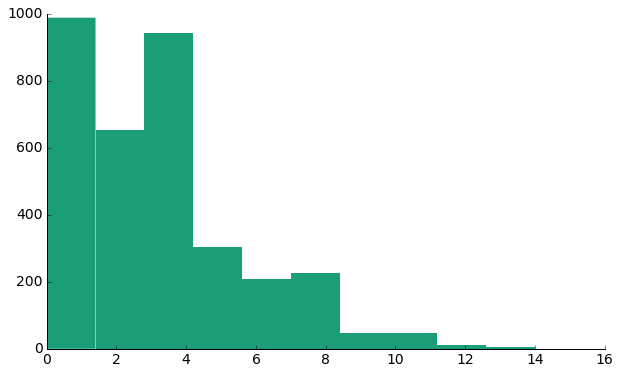

In [73]:
plt.hist(iv_df.num_nonemp_spells)
remove_border()

In [74]:
# export to csv
iv_df.to_csv('../data/iv_df.csv', index=False)